In [20]:
# Download dataset from Kaggle
!kaggle datasets download -d tunguz/big-five-personality-test


Dataset URL: https://www.kaggle.com/datasets/tunguz/big-five-personality-test
License(s): other
100%|███████████████████████████████████████▉| 159M/159M [00:30<00:00, 5.50MB/s]
100%|████████████████████████████████████████| 159M/159M [00:30<00:00, 5.39MB/s]


In [21]:
# Extract dataset
import zipfile

with zipfile.ZipFile('big-five-personality-test.zip', 'r') as zip_ref:
    zip_ref.extractall('personality_data')

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import pickle

In [2]:
data = pd.read_csv('data-final.csv',delimiter='\t')


In [3]:
# Keep relevant columns
data = data.iloc[:, :50]

In [4]:
# Check for missing values and drop them
data.dropna(inplace=True)

In [5]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
# Save train and test data to Excel files
train_data.to_excel('train_data.xlsx', index=False)
test_data.to_excel('test_data.xlsx', index=False)

In [22]:
# Question mappings for personality traits
questions = {
    'EXT': {f'EXT{i}': f'Extroversion Q{i}' for i in range(1, 11)},
    'EST': {f'EST{i}': f'Neuroticism Q{i}' for i in range(1, 11)},
    'AGR': {f'AGR{i}': f'Agreeableness Q{i}' for i in range(1, 11)},
    'CSN': {f'CSN{i}': f'Conscientiousness Q{i}' for i in range(1, 11)},
    'OPN': {f'OPN{i}': f'Openness Q{i}' for i in range(1, 11)},
}

In [ ]:
# Grouping columns by personality traits
traits = {key: [col for col in data.columns if col.startswith(key)] for key in questions.keys()}


In [25]:
#Visualization function
def visualize_trait_distribution(group_name, trait_questions, color, data, bins=10, alpha=0.7, figsize=(18, 24)):
    plt.figure(figsize=figsize)
    for idx, col in enumerate(group_name):
        plt.subplot(len(group_name) // 2 + 1, 2, idx + 1)
        plt.hist(data[col], bins=bins, color=color, alpha=alpha)
        plt.title(trait_questions[col], fontsize=10)
    plt.tight_layout()
    plt.show()


EXT Trait Distribution:


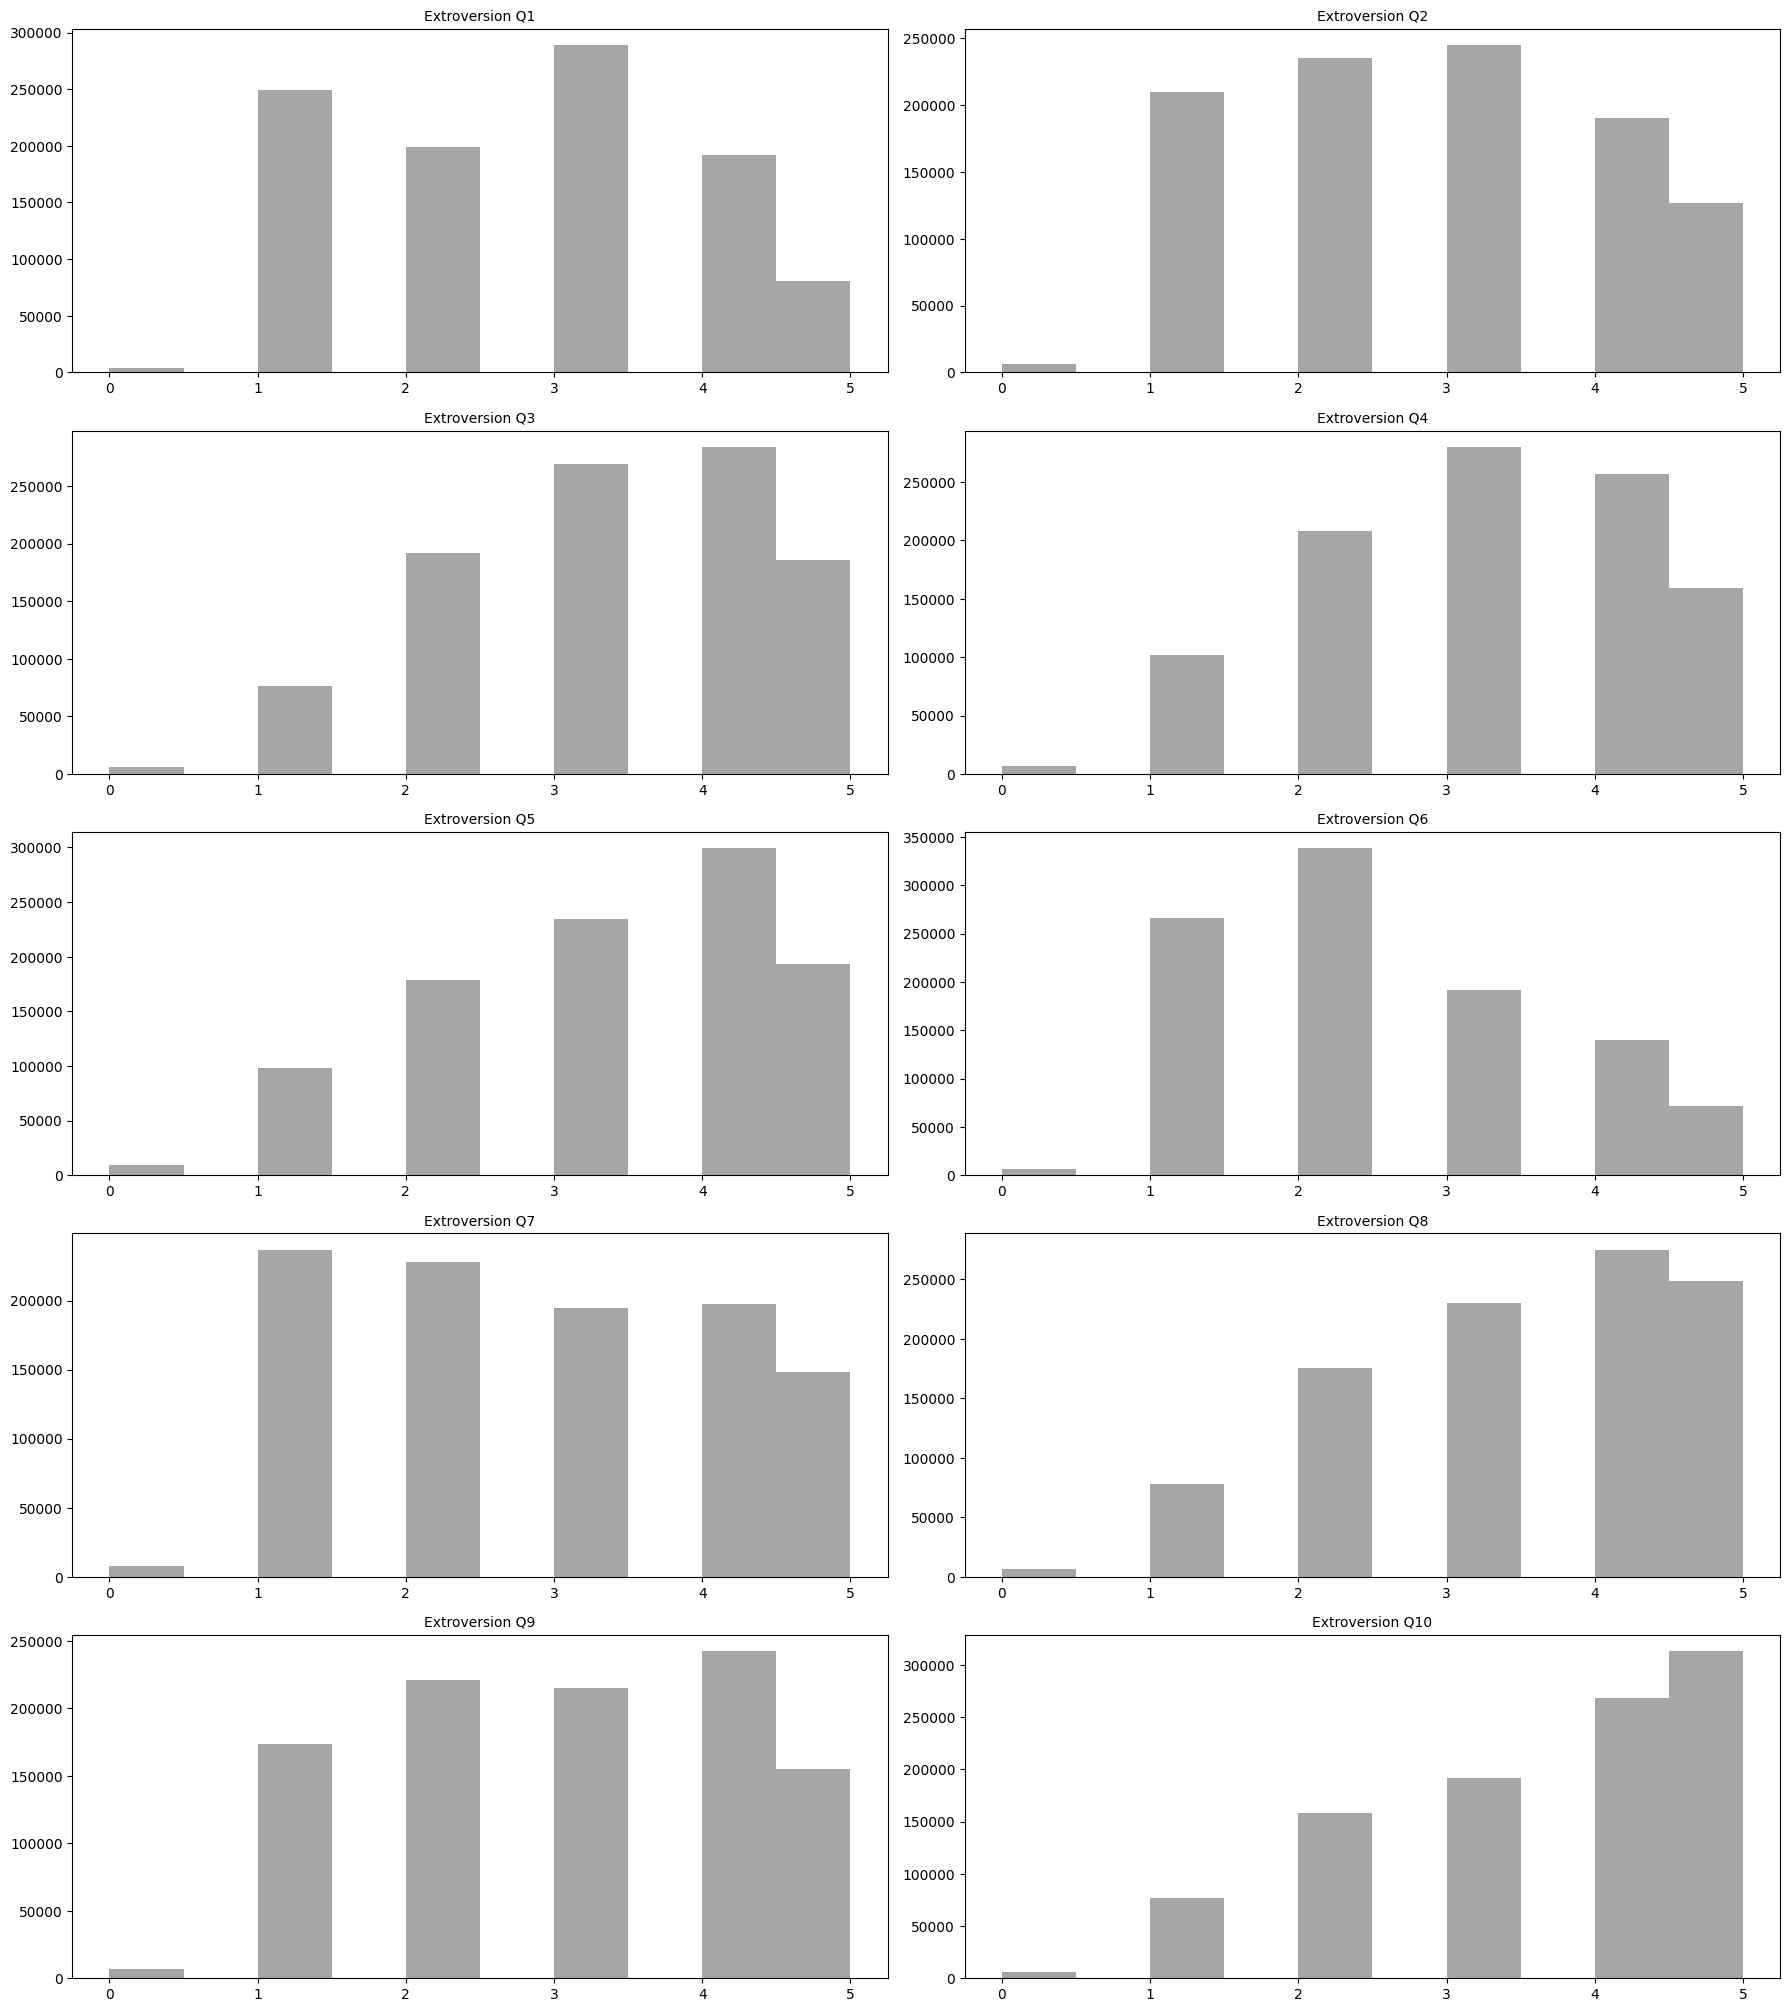

EST Trait Distribution:


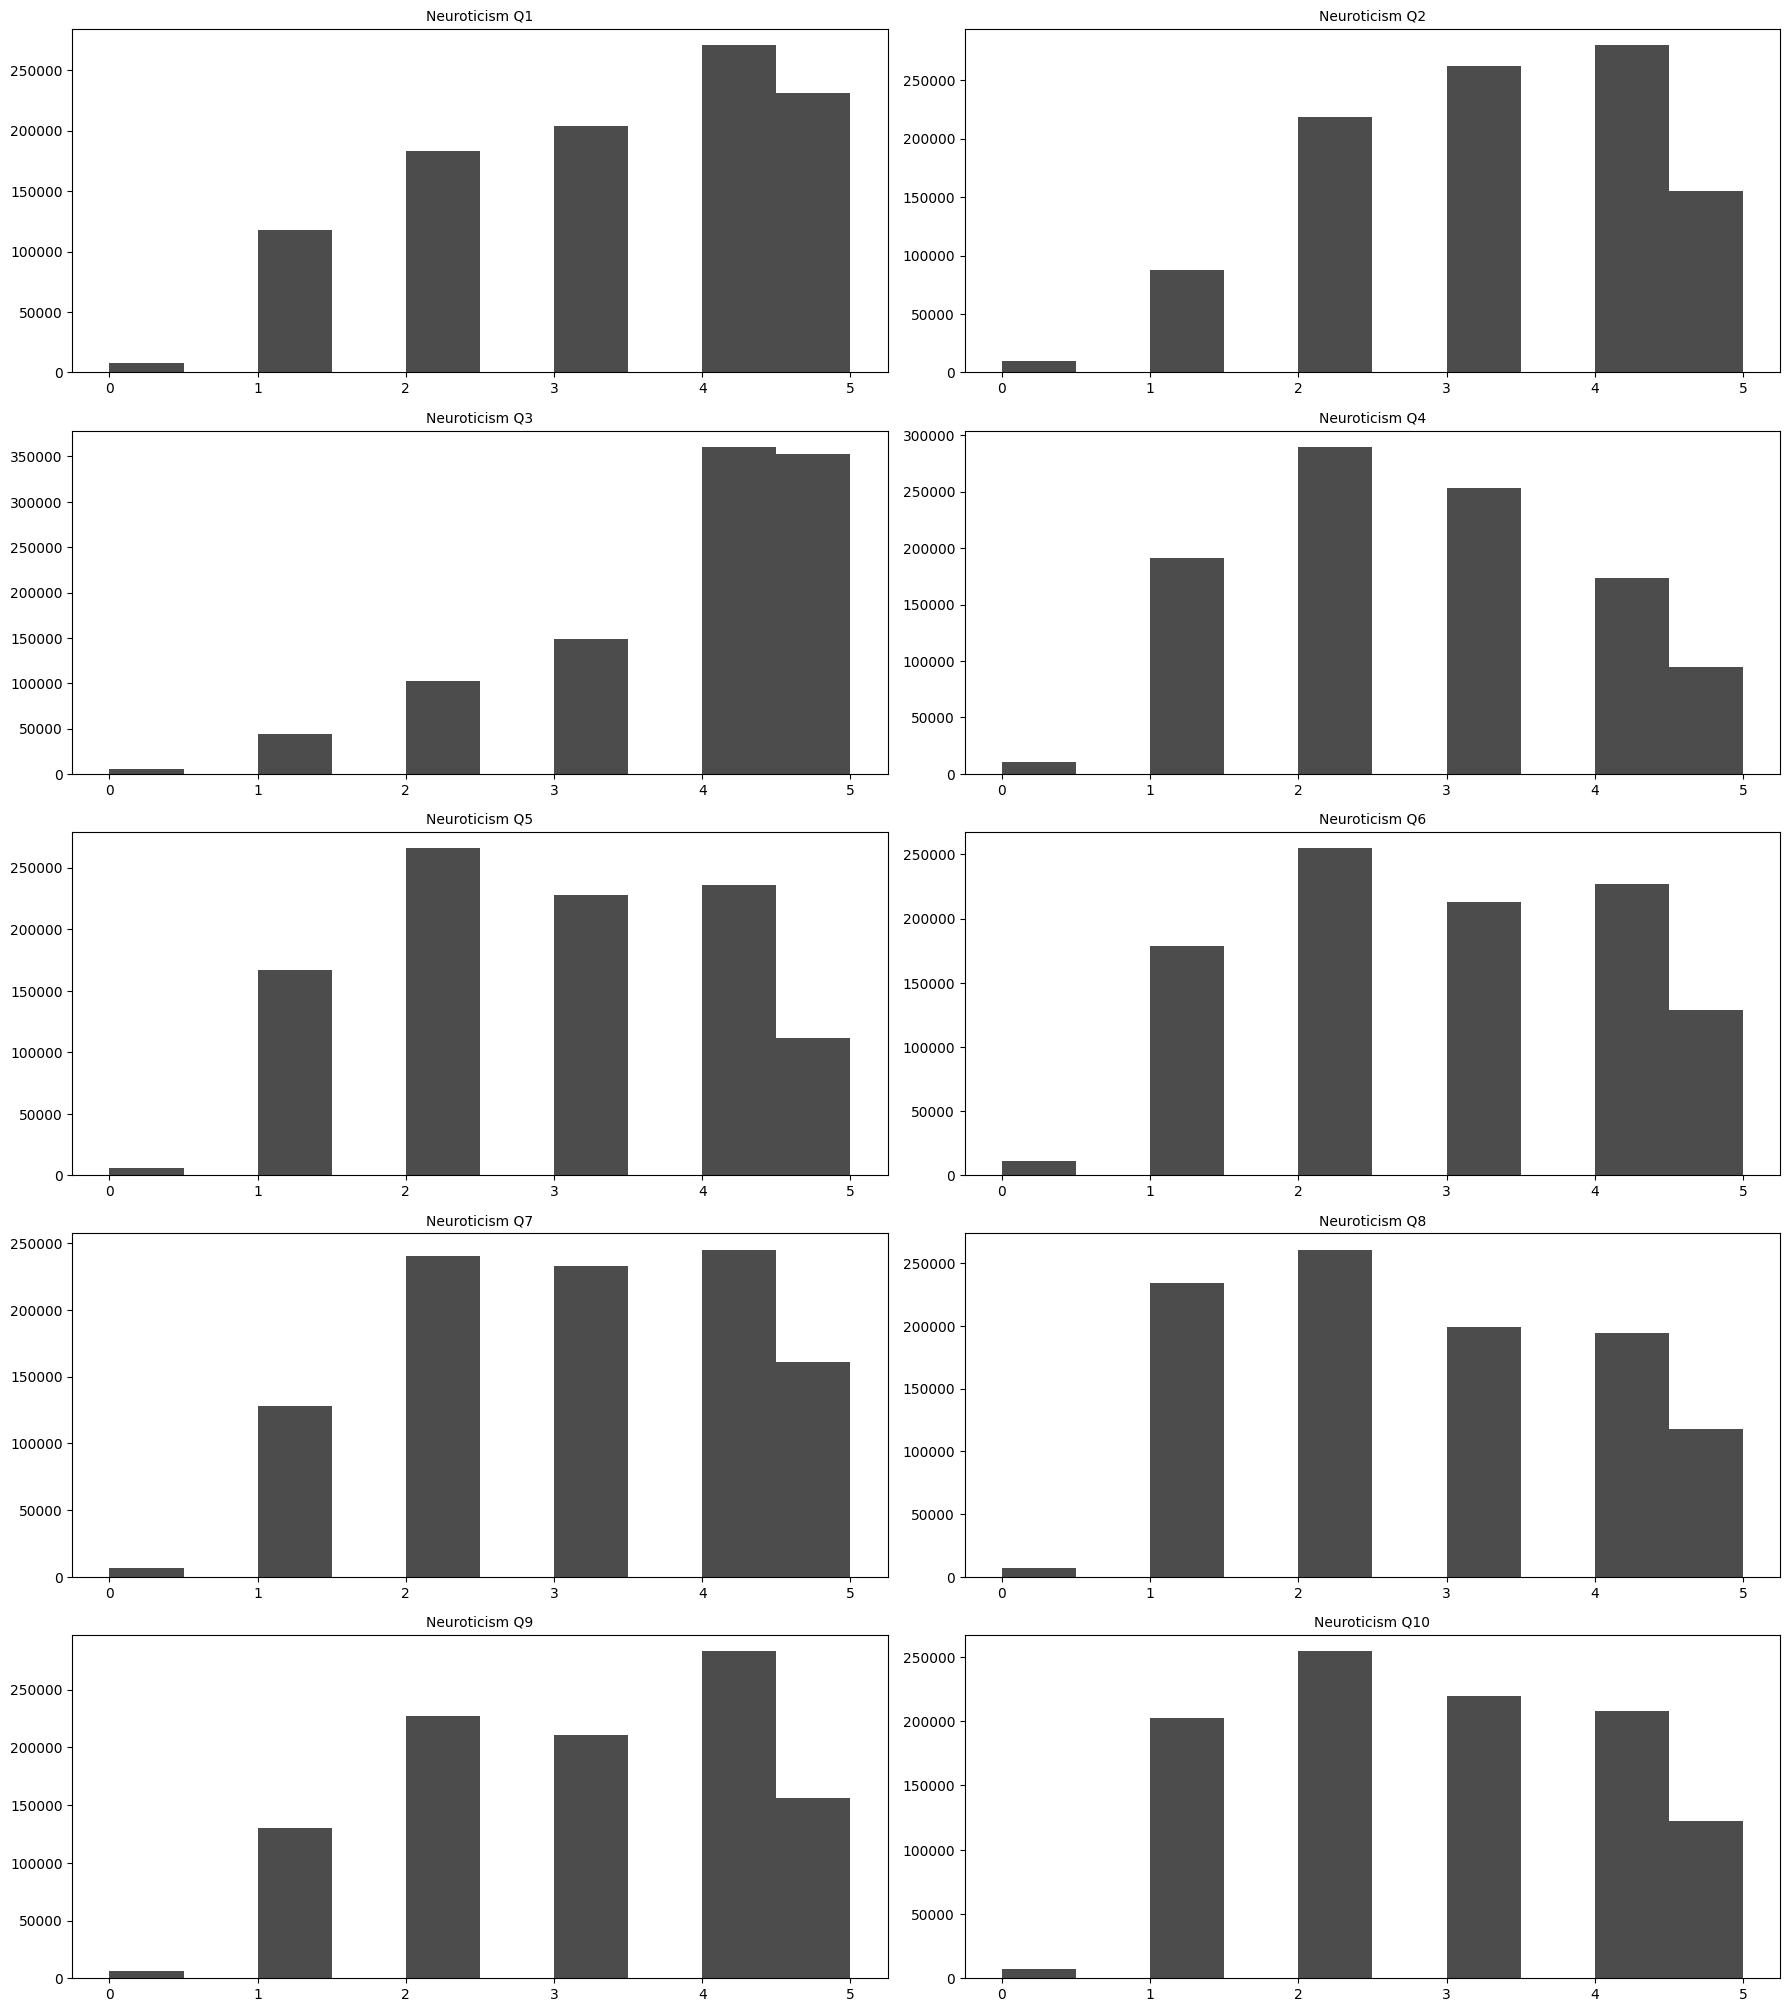

AGR Trait Distribution:


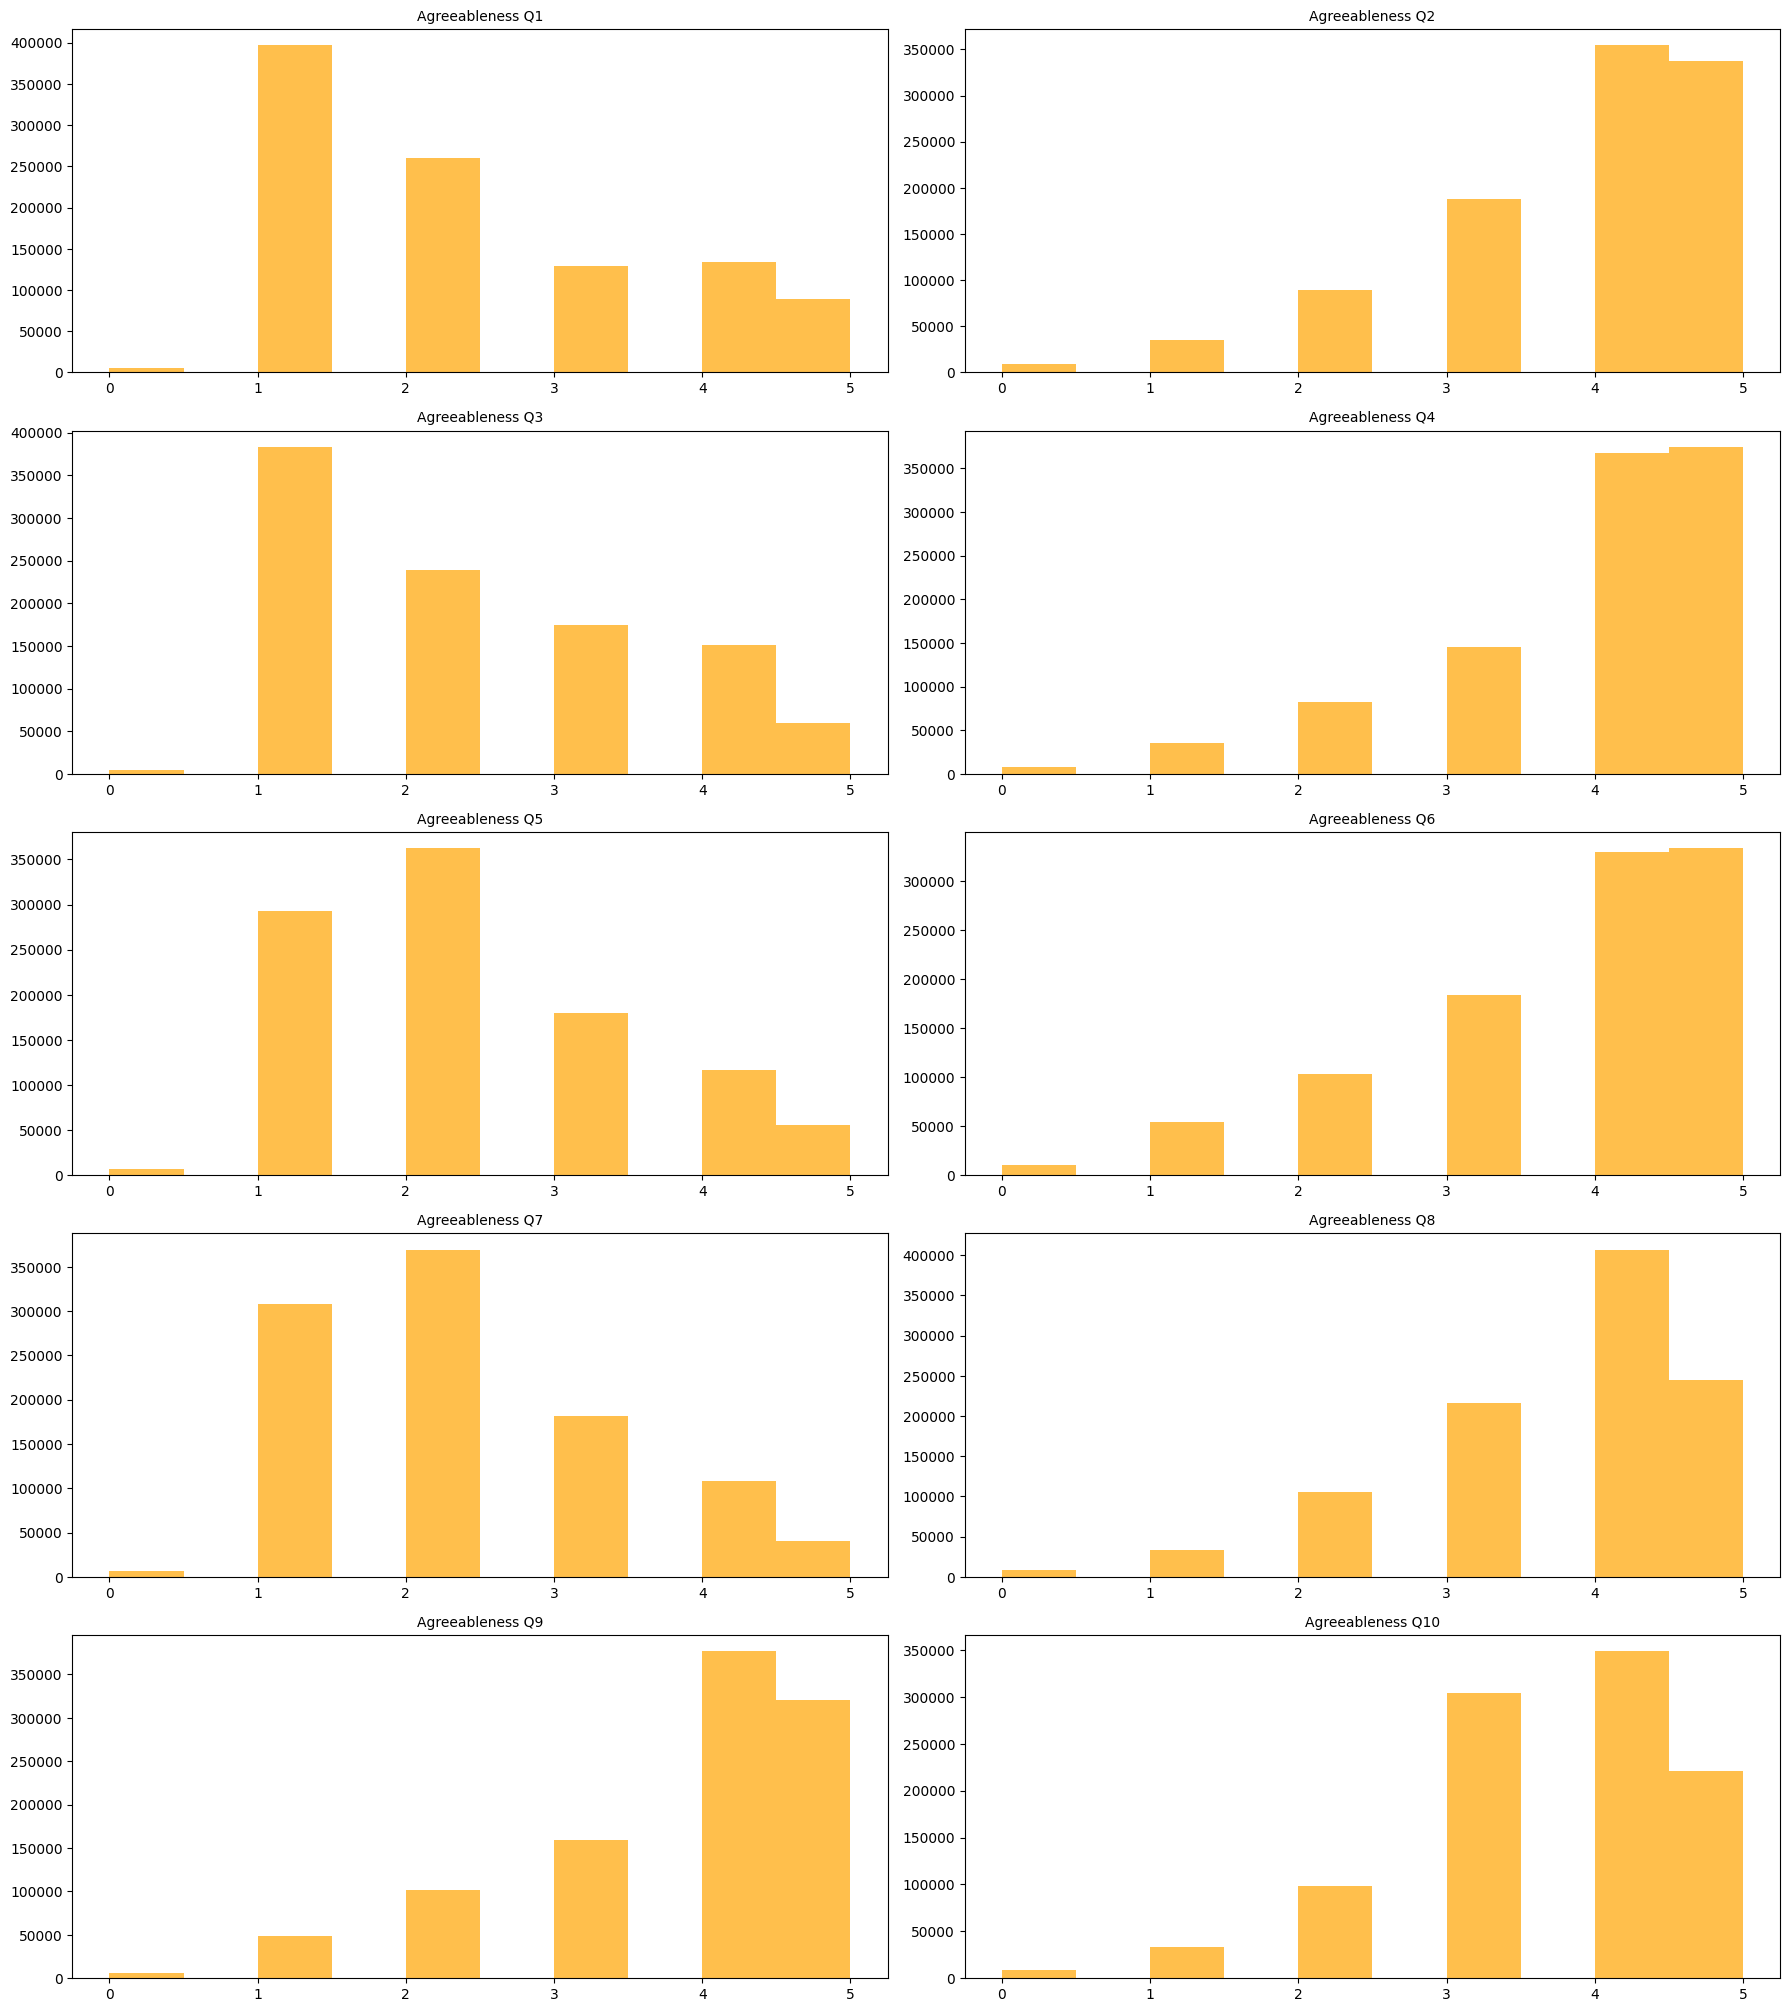

CSN Trait Distribution:


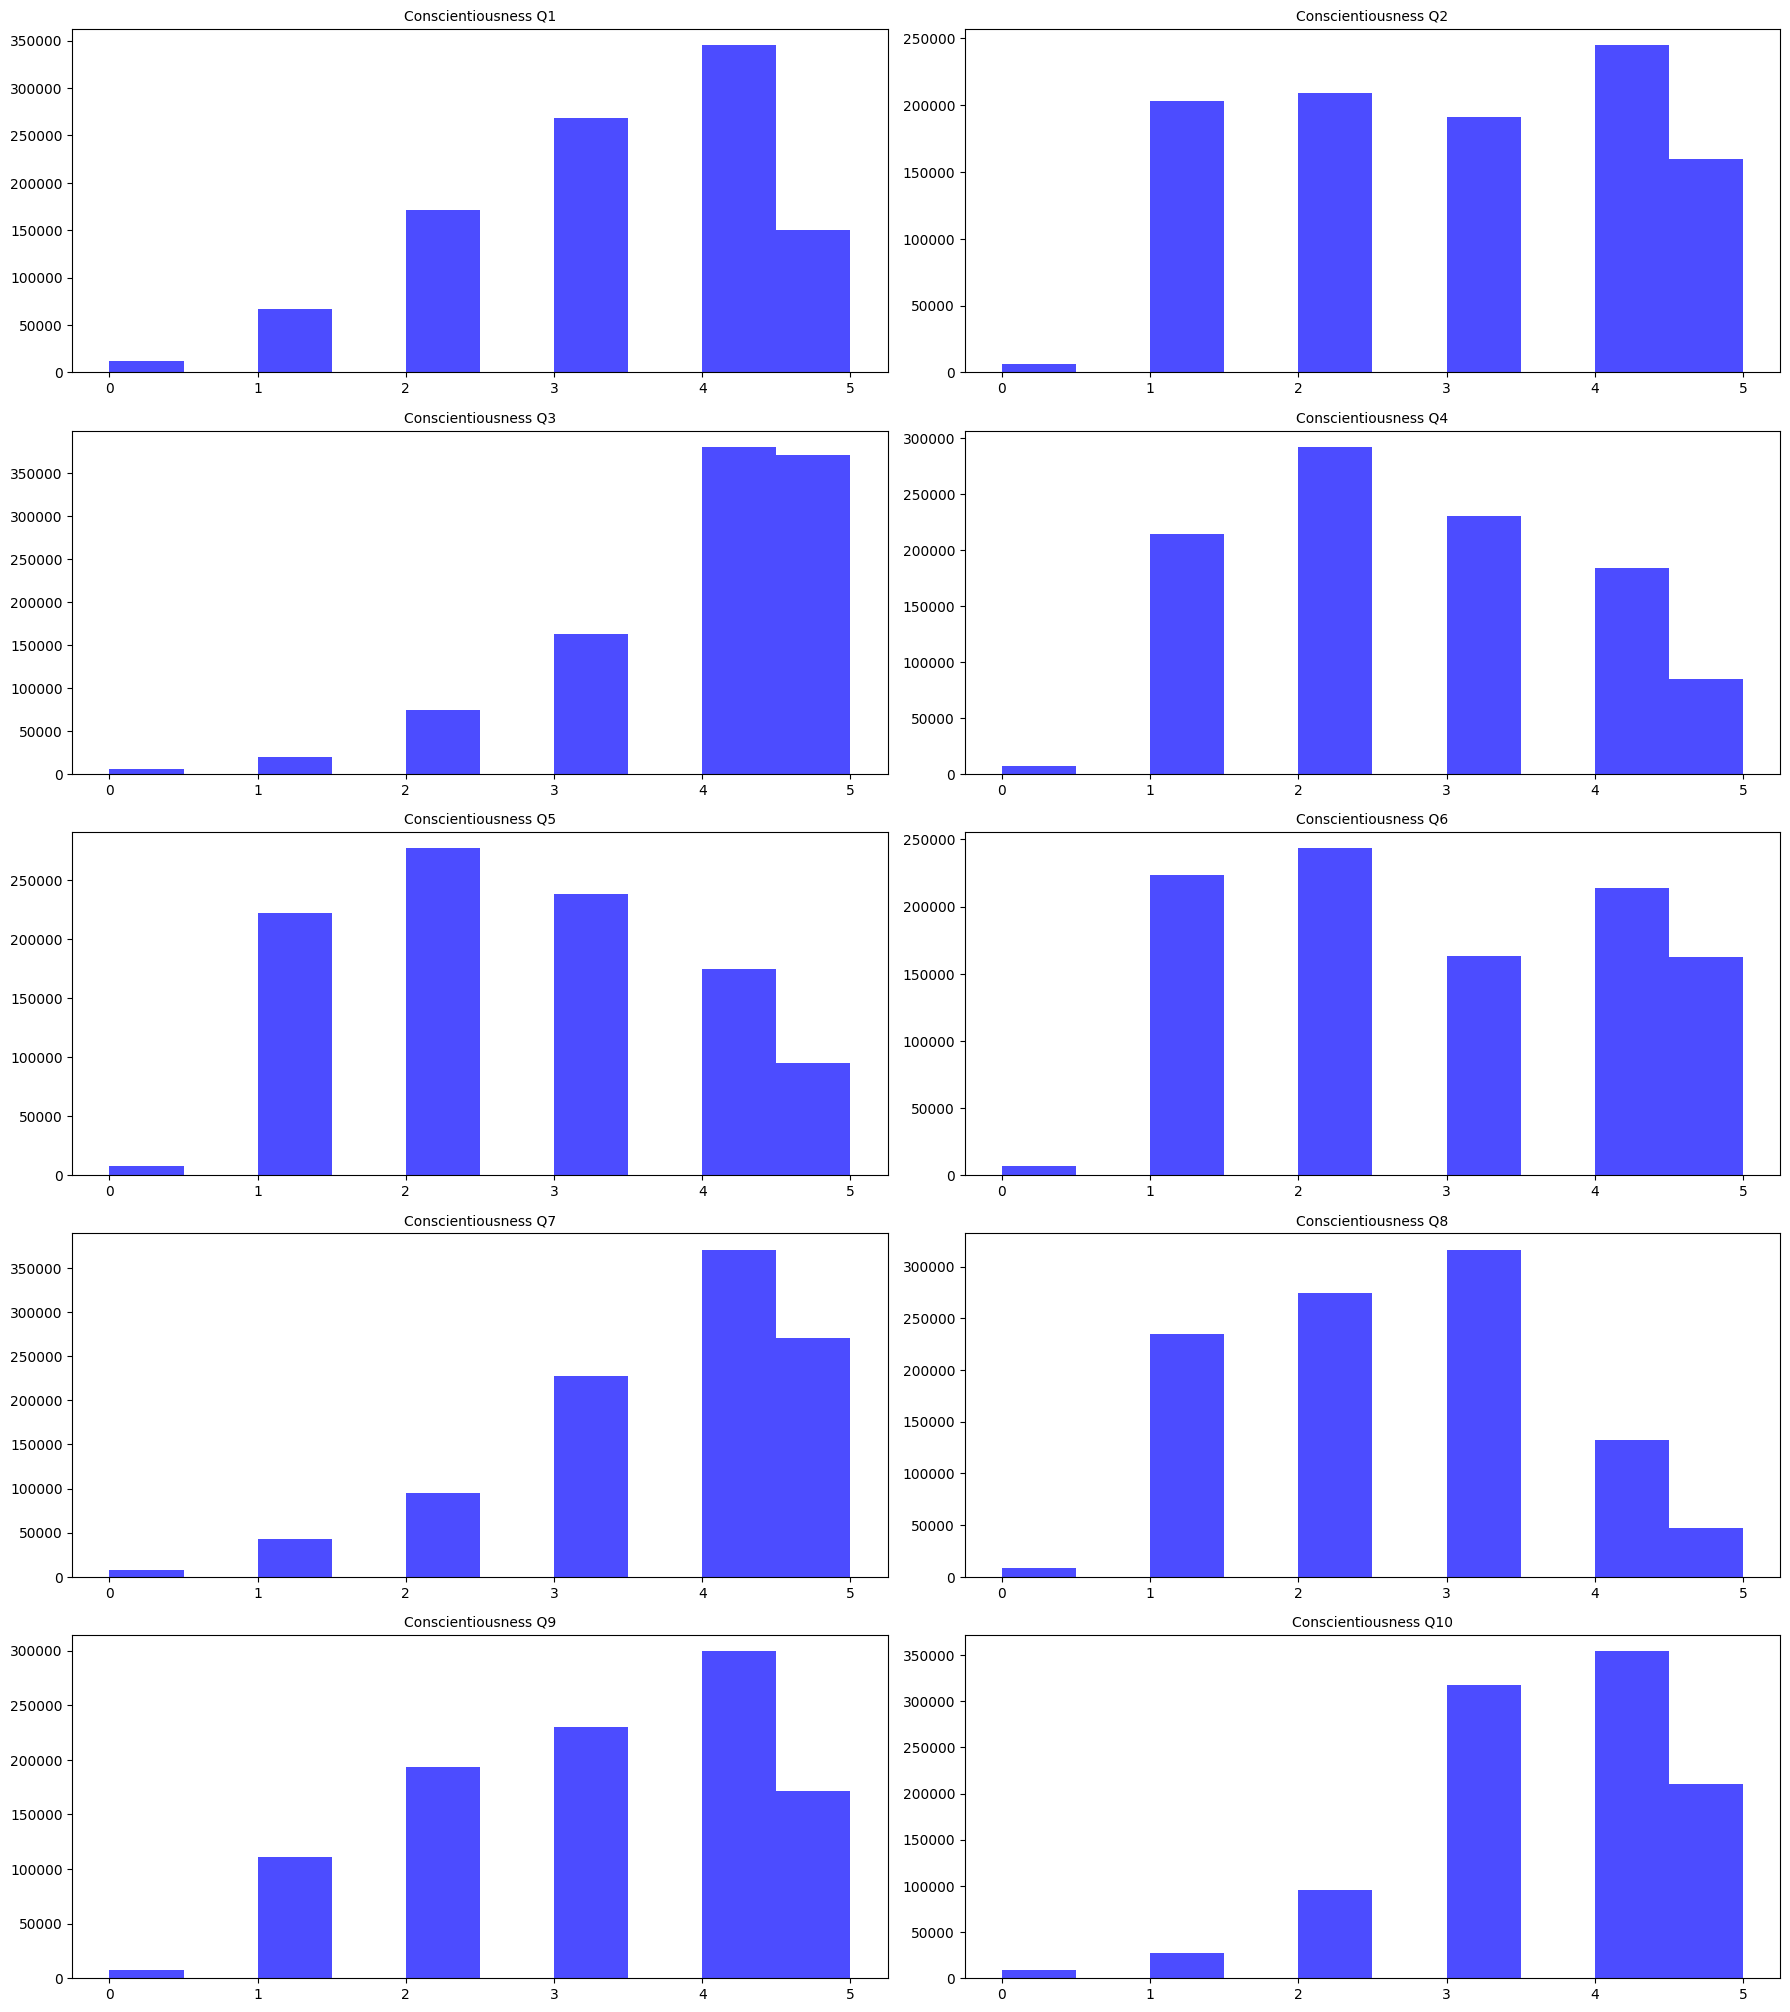

OPN Trait Distribution:


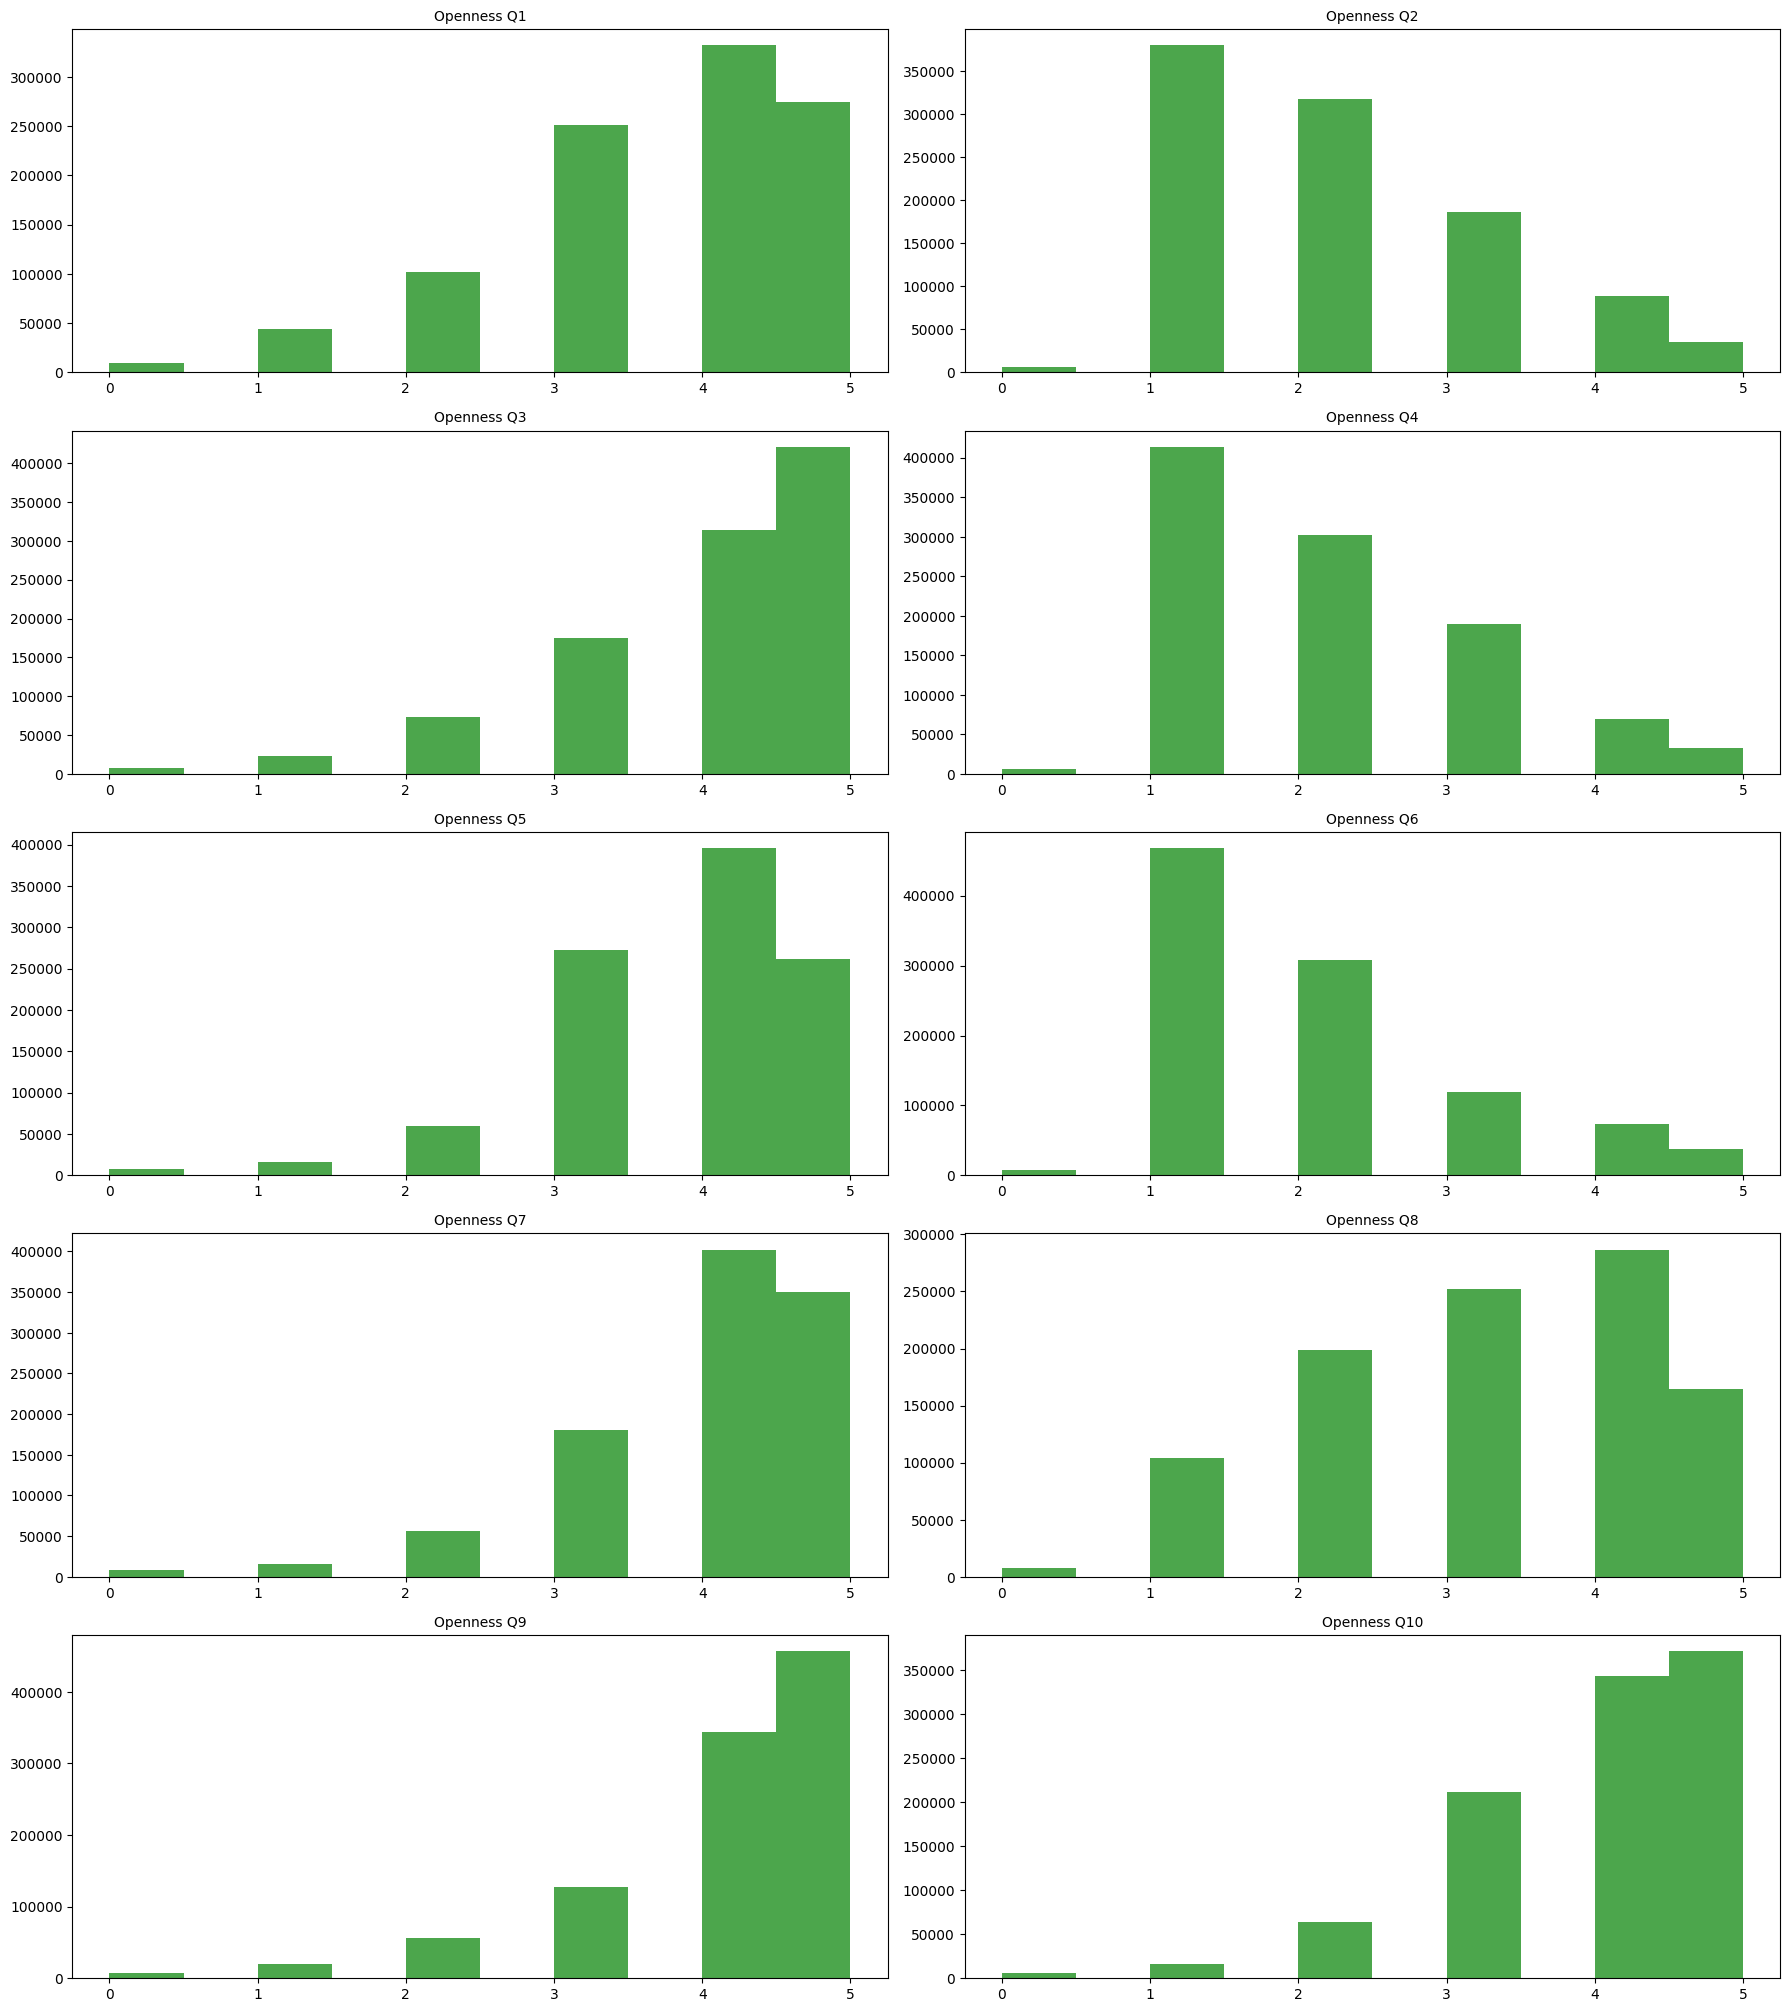

In [26]:
# Visualize each trait
for trait, color in zip(traits.keys(), ['grey', 'black', 'orange', 'blue', 'green']):
    print(f'{trait} Trait Distribution:')
    visualize_trait_distribution(traits[trait], questions[trait], color, data)

In [28]:
# K-Means clustering
clustering_data = data.copy()

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(clustering_data)

# Assign clusters to data
clustering_data['Cluster'] = kmeans.labels_


In [29]:
# Feature engineering for mean scores
mean_scores = pd.DataFrame({
    'Extroversion': clustering_data[traits['EXT']].mean(axis=1),
    'Neuroticism': clustering_data[traits['EST']].mean(axis=1),
    'Agreeableness': clustering_data[traits['AGR']].mean(axis=1),
    'Conscientiousness': clustering_data[traits['CSN']].mean(axis=1),
    'Openness': clustering_data[traits['OPN']].mean(axis=1),
    'Cluster': clustering_data['Cluster']
})

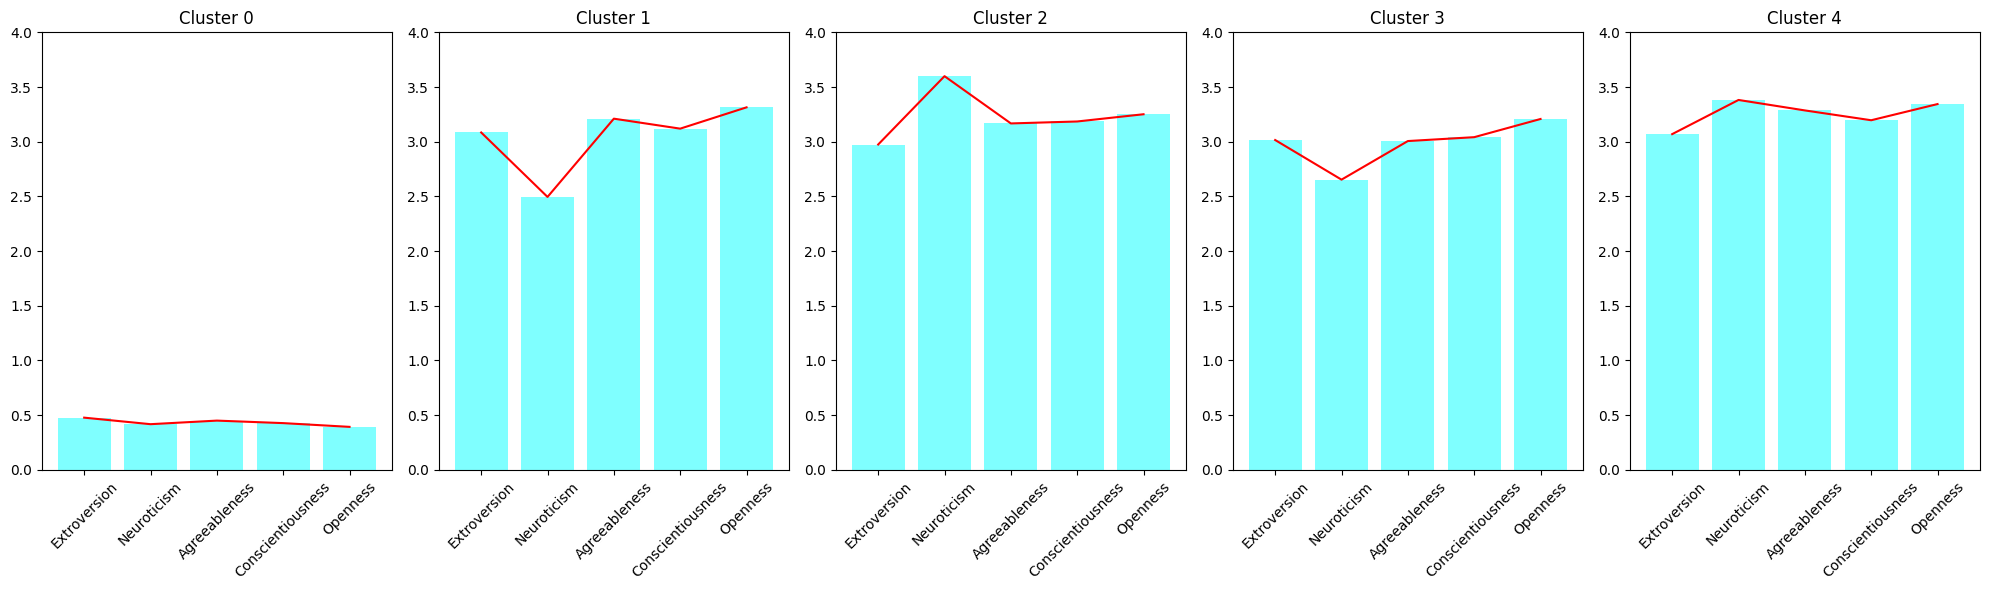

In [30]:
# Visualize mean scores by cluster
cluster_means = mean_scores.groupby('Cluster').mean()
plt.figure(figsize=(20, 6))
for i, cluster in enumerate(cluster_means.index):
    plt.subplot(1, 5, i + 1)
    plt.bar(cluster_means.columns, cluster_means.loc[cluster], color='cyan', alpha=0.5)
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], color='red')
    plt.title(f'Cluster {cluster}')
    plt.xticks(rotation=45)
    plt.ylim(0, 4)
plt.tight_layout()
plt.show()

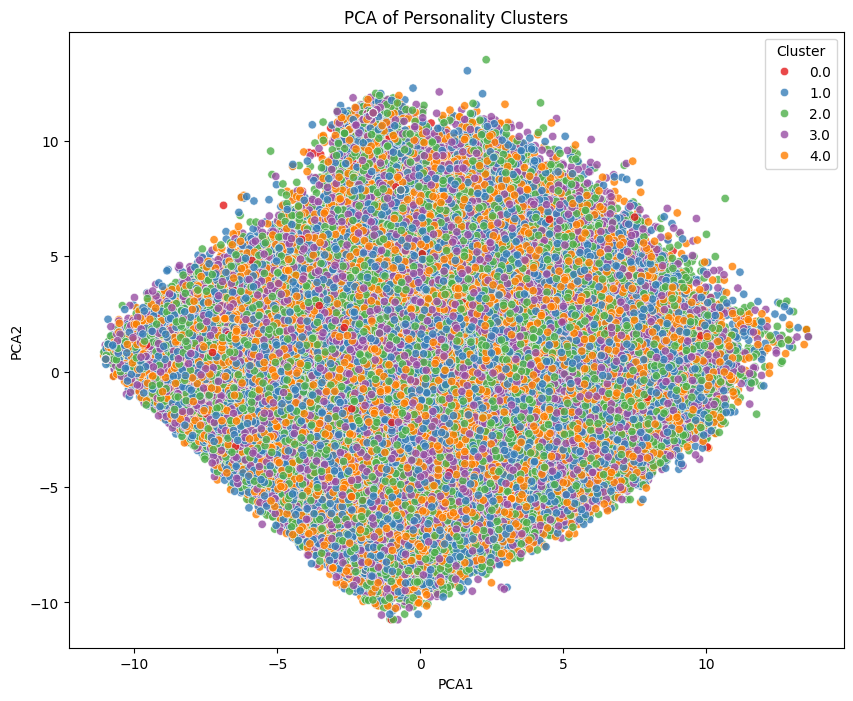

In [31]:
# PCA for 2D visualization
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(clustering_data.drop('Cluster', axis=1))

pca_df = pd.DataFrame(data=pca_transformed, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clustering_data['Cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', alpha=0.8)
plt.title('PCA of Personality Clusters')
plt.show()

In [32]:
# Prepare data for classification
X = clustering_data.drop('Cluster', axis=1)
y = clustering_data['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=100,         # Number of trees in the forest
    max_depth=None,           # No limit on depth
    min_samples_split=2,      # Minimum samples required to split an internal node
    min_samples_leaf=1,       # Minimum samples required to be at a leaf node
    random_state=42,
    n_jobs=-1                 # Use all available cores
)

In [41]:
# Fit the model
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [42]:
# Evaluate the model
y_pred = clf.predict(X_test)
print("Model Accuracy with Random Forest:", accuracy_score(y_test, y_pred))


Model Accuracy with Random Forest: 0.9093936224791823


In [44]:
# Save and test on new data
pickle.dump(clf, open('trained_model.pkl', 'wb'))

In [45]:
# Load and test
new_clf = pickle.load(open('trained_model.pkl', 'rb'))

predictions = new_clf.predict(test_data)

print("Predictions on new data:", predictions)

Predictions on new data: [2 1 4 ... 1 2 2]


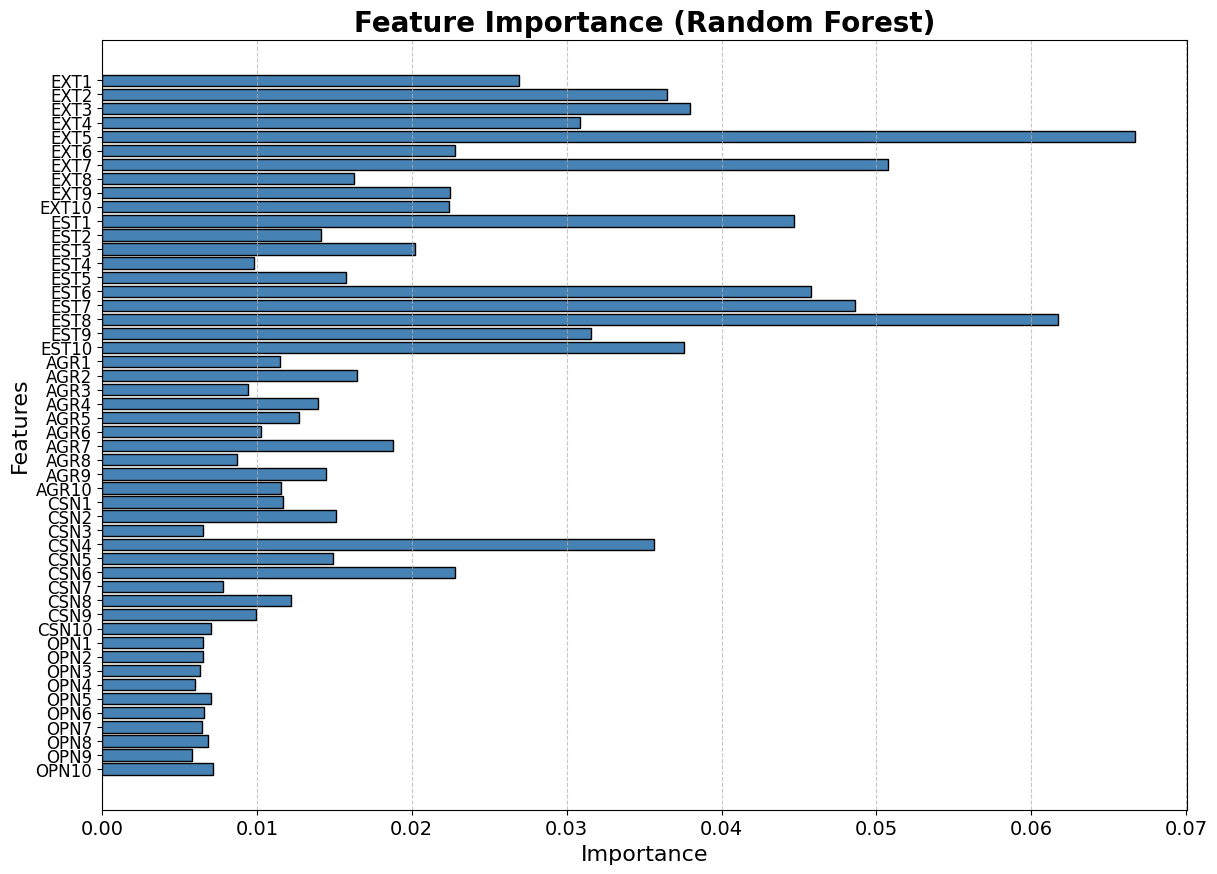

In [48]:
# Feature importance
plt.figure(figsize=(14, 10))  # Increase the figure size for better visibility
plt.barh(X.columns, clf.feature_importances_, color='steelblue', edgecolor='black')
plt.title('Feature Importance (Random Forest)', fontsize=20, fontweight='bold')
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()